# GPT-4o QA + context Evaluator (Batch Mode) v1
This notebook uses GPT-4o to evaluate the relevance, faithfulness and completeness of RAG-generated answers based on the provided context and question.
It batches 10 items per call for cost and performance efficiency.

v0 - baseline few shot only <br>
v1 - prompt tuning (gpt-4o)<br>
*   add explanations to few shot examples
*   improve prompt (system message, all rubrics)




In [107]:
!pip install openai pandas

# Imports

In [108]:
import os
import pandas as pd
import json
import time
import re
import numpy as np

# openAI
from openai import OpenAI

# drive
from google.colab import drive
from google.colab import userdata

# stats
from scipy.stats import spearmanr, pearsonr, kendalltau

In [109]:
# Google Drive Setup

# mount google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [110]:
!ls '/content/drive/MyDrive/Colab Notebooks/final_project_266'

 200_questions.csv
 266_FP_Phase_Z_Scores.xlsx
 266_FP_SO_evaluator_gpt4.ipynb
 266_FP_SO_QExtract_gpt4.ipynb
 266_SO_RAGAS_evaluator.ipynb
 batch_requests_eval.jsonl
 batch_requests.jsonl
 cleaned_batch_requests_eval.jsonl
 context_question_answer_only.csv
 context_question_answer_only.gsheet
 extracted_passages_Jnana.csv
 final_scored_all_20_qa_pairs_v3.xlsx
'full_generated_q_a_jnana (1).csv'
 full_generated_q_a_jnana.csv
 generated_q_a_df_25passages.csv
 generated_q_a_df.csv
 generated_q_a_df.gsheet
 get_qa.ipynb
 golden_scores_20_eval_7-30-25.csv
 golden_scores_20_eval_7-30-25.gsheet
 golden_scores_20_eval_7-31-25_v0.csv
 golden_scores_20_eval_8-1-25_v1.csv
 gpt4o-mini_QA_evaluator_v0.ipynb
 gpt4o-mini_QA_evaluator_v1.ipynb
 gpt4o-mini_QA_evaluator_v2.ipynb
 gpt_evaluator_scores_v1-results_8-2-2025.xlsx
 gpt_evaluator_scores_v1.xlsx
 gpt_evaluator_scores_v2_0-explained.xlsx
 gpt_evaluator_scores.xlsx
 llama8B_control_group_generate_answers.ipynb
 llama_baseline_eval_7-30-25.csv
 ll

# Data Setup - File Paths and Data Frames

In [111]:
def fix_mojibake(text):
    if not isinstance(text, str):
        return text
    return (text.replace('‚Äú', '"')
                .replace('‚Äù', '"')
                .replace('‚Äò', "'")
                .replace('‚Äô', "'")
                .replace('â€”', '—')
                .replace('â€“', '–')
                .replace('Ã©', 'é')
                .replace('â€˜', "'")
                .replace('â€™', "'")
                .replace('â€œ', '"')
                .replace('â€', '"')
                .replace('Â', ''))

## Data Setup: Unit Tests

In [112]:
golden_scores_path = '/content/drive/MyDrive/Colab Notebooks/final_project_266/final_scored_all_20_qa_pairs_v3.xlsx'

In [113]:
golden_scores_df = pd.read_excel(golden_scores_path)
golden_scores_df = golden_scores_df.rename(columns={'Passage': 'context',
                                                    'Insightful Question': 'question',
                                                    'Answer': 'answer',
                                                    'Relevance': 'relevance',
                                                    'Factual Accuracy': 'faithfulness',
                                                    'Completeness': 'completeness'})

golden_scores_df = golden_scores_df[['context', 'question', 'answer', 'relevance', 'faithfulness', 'completeness']]
golden_scores_df['relevance'] = golden_scores_df['relevance'].round(0)
golden_scores_df['faithfulness'] = golden_scores_df['faithfulness'].round(0)
golden_scores_df['completeness'] = golden_scores_df['completeness'].round(0)

for col in golden_scores_df.columns:
  golden_scores_df[col] = golden_scores_df[col].apply(fix_mojibake)

# golden_scores_df


In [114]:
q_a_only = golden_scores_df[['context', 'question', 'answer']]
# q_a_only

## Data Setup: Llama baseline (no tuning)


In [115]:
llama_baseline_path = '/content/drive/MyDrive/Colab Notebooks/final_project_266/266_FP_Phase_Z_Scores.xlsx'

In [116]:
llama_baseline_results_df = pd.read_excel(llama_baseline_path, sheet_name='HUMAN.CG.BASE.LLAMA')
llama_baseline_results_df = llama_baseline_results_df.rename(columns={'passage': 'context',
                                                                      'generated_answer': 'answer'})
llama_baseline_results_df = llama_baseline_results_df[['context', 'question', 'answer', 'relevance', 'faithfulness', 'completeness']]
llama_baseline_results_df = llama_baseline_results_df[0:50]

for col in llama_baseline_results_df.columns:
  llama_baseline_results_df[col] = llama_baseline_results_df[col].apply(fix_mojibake)

# drop q18 since it was moved to unit
llama_baseline_results_df = llama_baseline_results_df.drop(index=[18])
llama_baseline_results_df.reset_index(drop=True, inplace=True)

llama_baseline_results_df.head()

,context,question,answer,relevance,faithfulness,completeness
0,"N. KASTURI Editor, Sanathana Sarathi JNANA V A...",What role do practices like Bhajan play in the...,The passage does not mention Bhajan or any oth...,2.0,2.0,1.0
1,It is only when full knowledge is won that one...,What is necessary to overcome the challenges t...,To overcome the challenges that arise during D...,4.0,4.0,3.0
2,It is only when full knowledge is won that one...,What is the result of attaining Moksha as desc...,The result of attaining Moksha (Liberation) is...,3.0,1.0,2.0
3,The Sadhaka (aspirant for spiritual progress) ...,What is the source of joy for the Jnani?,The context does not mention the source of joy...,2.0,1.0,2.0
4,"Overfeeding,exhaustion through too much of mov...","What is the significance of the phrase ""Brahma...","There is no mention of the phrase ""Brahmavith ...",3.0,1.0,2.0


In [117]:
llama_baseline_qa_df = llama_baseline_results_df[['context', 'question', 'answer']]
llama_baseline_qa_df.head()

,context,question,answer
0,"N. KASTURI Editor, Sanathana Sarathi JNANA V A...",What role do practices like Bhajan play in the...,The passage does not mention Bhajan or any oth...
1,It is only when full knowledge is won that one...,What is necessary to overcome the challenges t...,To overcome the challenges that arise during D...
2,It is only when full knowledge is won that one...,What is the result of attaining Moksha as desc...,The result of attaining Moksha (Liberation) is...
3,The Sadhaka (aspirant for spiritual progress) ...,What is the source of joy for the Jnani?,The context does not mention the source of joy...
4,"Overfeeding,exhaustion through too much of mov...","What is the significance of the phrase ""Brahma...","There is no mention of the phrase ""Brahmavith ..."


## Data Setup: Llama fine-tuned model results


In [118]:
llama_fine_tuned_path = '/content/drive/MyDrive/Colab Notebooks/final_project_266/266_FP_Phase_Z_Scores.xlsx'

In [119]:
llama_tuned_scored_df = pd.read_excel(llama_fine_tuned_path, sheet_name='HUMAN.fine_tuned_llama')
# llama_tuned_scored_df
llama_tuned_scored_df = llama_tuned_scored_df.rename(columns={'passage': 'context',
                                                              'gen_answer': 'answer',
                                                              'Relevance' : 'relevance',
                                                              'Faithfulness' : 'faithfulness',
                                                              'Completeness' : 'completeness'})
llama_tuned_scored_df = llama_tuned_scored_df[['context','question', 'answer', 'relevance', 'faithfulness', 'completeness']]
llama_tuned_scored_df = llama_tuned_scored_df[0:50]

for col in llama_tuned_scored_df.columns:
  llama_tuned_scored_df[col] = llama_tuned_scored_df[col].apply(fix_mojibake)

llama_tuned_scored_df = llama_tuned_scored_df.drop(index=[18])
llama_tuned_scored_df.reset_index(drop=True, inplace=True)
# llama_tuned_scored_df

In [120]:
llama_tuned_q_a_only = llama_tuned_scored_df[['context', 'question', 'answer']]
# llama_tuned_q_a_only

## Data Setup: RAG

In [121]:
rag_scored_path = '/content/drive/MyDrive/Colab Notebooks/final_project_266/266_FP_Phase_Z_Scores.xlsx'

In [122]:
rag_scored_df = pd.read_excel(rag_scored_path, sheet_name='HUMAN.ph_z_50_rag')
rag_scored_df = rag_scored_df.rename(columns={'generated_answer' : 'answer',
                                              'Relevance' : 'relevance',
                                              'Faithfulness' : 'faithfulness',
                                              'Completeness' : 'completeness'})
rag_scored_df = rag_scored_df[['question', 'answer', 'relevance', 'faithfulness', 'completeness']]
rag_scored_df = rag_scored_df[0:50]

for col in rag_scored_df.columns:
  rag_scored_df[col] = rag_scored_df[col].apply(fix_mojibake)

# rag_scored_df.head()

In [123]:
# add context column for RAG evaluation
rag_scored_df['context'] = llama_tuned_q_a_only['context'][0:50]
rag_qa_df = rag_scored_df[['context', 'question', 'answer']]
# rag_qa_df.head()

In [124]:
## add rag 18 to golden scores --> few shot examples

golden_scores_df = pd.concat([golden_scores_df, rag_scored_df.iloc[[19]]], ignore_index=True)
# golden_scores_df = pd.concat([golden_scores_df, rag_scored_df.iloc[[19]]], ignore_index=True)


In [125]:
# remove questions from data
rag_scored_df = rag_scored_df.drop(index=[19])
rag_qa_df = rag_qa_df.drop(index=[19])

# rag_scored_df = rag_scored_df.drop(index=[18, 19])
# rag_qa_df = rag_qa_df.drop(index=[18, 19])

rag_scored_df.reset_index(drop=True, inplace=True)
rag_qa_df.reset_index(drop=True, inplace=True)

# OpenAI setup

In [126]:
# OpenAI setup

# Set your OpenAI API key here
os.environ['OPENAI_API_KEY'] = ''


# Functions

In [127]:
def generate_few_shot_prompt(few_shot_df, metric):
    """
    Generate few-shot prompt examples for a specific metric.

    Args:
        few_shot_df (pd.DataFrame): DataFrame with few-shot examples.
        metric (str): One of 'relevance', 'faithfulness', or 'completeness'.

    Returns:
        str: Formatted few-shot prompt with examples.
    """

    assert metric in {"relevance", "faithfulness", "completeness"}, "Invalid metric."

    lines = [f"Examples for evaluating {metric}:"]

    for i, row in few_shot_df.iterrows():
        lines.append(f"Item {i}:")
        lines.append(f"Question: {row['question']}")
        lines.append(f"Context: {row['context']}")
        lines.append(f"Answer: {row['answer']}")
        lines.append(f"{metric.capitalize()}: {row[metric]}")

        # include explanations if available
        explanation_col = f"{metric}_explanation"
        if explanation_col in row and pd.notnull(row[explanation_col]):
            lines.append(f"Explanation: {row[explanation_col]}")

        lines.append("")  # blank line between examples

    return "\n".join(lines).strip()


In [128]:
def count_big_delta(diff_df):
  numeric_diff = diff_df.copy()

  # Flatten the column index (if it's a MultiIndex)
  if isinstance(numeric_diff.columns, pd.MultiIndex):
      numeric_diff.columns = ['_'.join(col).strip() for col in numeric_diff.columns.values]

  # Get all pairs of self/other columns
  self_cols = [col for col in numeric_diff.columns if col.endswith('_self')]
  other_cols = [col.replace('_self', '_other') for col in self_cols]

  # Count where absolute difference > 1
  count = 0
  for s_col, o_col in zip(self_cols, other_cols):
      diff = (numeric_diff[s_col] - numeric_diff[o_col]).abs()
      count += (diff > 1).sum()

  print("Number of self-to-other differences greater than 1:", count)

  return count



# GPT Evaluation Prompt

In [129]:
# few_shot_df = golden_scores_df[7:13]
# few_shot_df = golden_scores_df.iloc[[0,1,7,8,9,10,11,12]]
few_shot_df = golden_scores_df
few_shot_df.tail()

,context,question,answer,relevance,faithfulness,completeness
16,"This is the discipline called Brahmabhyasa, th...",How does the dissolution of the ego lead to ac...,"Without ego, one may act differently.",4.0,4.0,2.0
17,"They are like the mirage, which superimposes w...",What does it mean to live in time while rooted...,Living in time means existing with awareness.,4.0,4.0,2.0
18,"It is Brahmam, andBrahmam alone. All bonds of ...",Why does true spiritual transformation require...,"Self of knowing not change, mind like cloud is...",4.0,4.0,4.0
19,No attention is paid to the internal and the e...,In what way is self-realization described not ...,"Wise don't know they be wise, thinking they un...",4.0,4.0,4.0
20,He will see no distinction between man and man...,How does the analogy of the jack tree contribu...,I don't know. The passage does not mention the...,2.0,3.0,4.0


In [130]:
# few_shot_rel_df = golden_scores_df.iloc[[0, 9, 14, 19, 20, 21]]
# few_shot_faith_df = golden_scores_df.iloc[[0, 9, 14, 19, 20, 21]]
# few_shot_comp_df = golden_scores_df.iloc[[0, 9, 14, 19, 20, 21]]

few_shot_rel_df = golden_scores_df.iloc[[0, 9, 14, 19, 20]]
few_shot_faith_df = golden_scores_df.iloc[[0, 9, 14, 19, 20]]
few_shot_comp_df = golden_scores_df.iloc[[0, 9, 14, 19, 20]]

In [131]:
unit_test_scores_df = golden_scores_df.iloc[[1, 2, 4, 6, 7, 8,  11, 12, 13, 16, 17, 18, 10, 3, 5, 15]]
q_a_only = q_a_only.iloc[[1, 2, 4, 6, 7, 8, 11, 12, 13, 16, 17, 18, 10, 3, 5, 15]]

In [132]:
# remove unecessary columns
few_shot_rel_df = few_shot_rel_df[['context', 'question', 'answer', 'relevance']]
few_shot_faith_df = few_shot_faith_df[['context', 'question', 'answer', 'faithfulness']]
few_shot_comp_df = few_shot_comp_df[['context', 'question', 'answer', 'completeness']]
few_shot_rel_df

,context,question,answer,relevance
0,If it is stated that women are not entitled to...,How does the denial of scriptural access to wo...,The exclusion of women from Vedic study reflec...,5.0
9,Without a clear understanding of the play in w...,What does the metaphor of life as a 'play in w...,"Somethings move, other things stay stationary,...",3.0
14,"Deprive renunciation (Vairagya) of that basis,...",Is there a contradiction between bhakti (devot...,"Some say bhakti and jnana are alike, but other...",1.0
19,No attention is paid to the internal and the e...,In what way is self-realization described not ...,"Wise don't know they be wise, thinking they un...",4.0
20,He will see no distinction between man and man...,How does the analogy of the jack tree contribu...,I don't know. The passage does not mention the...,2.0


In [133]:
# add explanatioins to few shot examples - relevance
few_shot_rel_df['relevance_explanation'] = '1'

few_shot_rel_df.loc[0, 'relevance_explanation'] = 'The answer directly and specifically addresses the question by linking gender exclusion to Vedantic metaphysics, as described in the context. No irrelevant information is introduced.'
few_shot_rel_df.loc[9, 'relevance_explanation'] = 'The answer touches on the metaphor of movement but shifts entirely off-topic with the reference to “trucks and cars,” which is unrelated to the question or context. Partial topical overlap, but unfocused.'
few_shot_rel_df.loc[14, 'relevance_explanation'] = 'The answer does not address the question of whether bhakti and jnana are stages or contradictory. It makes a vague generalization and does not refer to any concepts in the passage.'
few_shot_rel_df.loc[19, 'relevance_explanation'] = 'The answer loosely aligns with the theme of self-realization as remembering, but the poetic phrasing is indirect and lacks full engagement with the context’s key ideas. Mostly on-topic but underdeveloped.'
# few_shot_rel_df.loc[20, 'relevance_explanation'] = 'The answer partially addresses the question by acknowledging the absence of Sabari and Sureswaracharya''s wife in the context, but also incorrectly references Arjuna and Krishna, who are not present in the provided passage. This distracts from the core focus.'
few_shot_rel_df.loc[20, 'relevance_explanation'] = 'The answer simply states "I don''t know" and does not attempt to engage with the question or passage. It avoids off-topic details, but it does not relate to the actual passage theme or question about the analogy.'

few_shot_rel_df

,context,question,answer,relevance,relevance_explanation
0,If it is stated that women are not entitled to...,How does the denial of scriptural access to wo...,The exclusion of women from Vedic study reflec...,5.0,The answer directly and specifically addresses...
9,Without a clear understanding of the play in w...,What does the metaphor of life as a 'play in w...,"Somethings move, other things stay stationary,...",3.0,The answer touches on the metaphor of movement...
14,"Deprive renunciation (Vairagya) of that basis,...",Is there a contradiction between bhakti (devot...,"Some say bhakti and jnana are alike, but other...",1.0,The answer does not address the question of wh...
19,No attention is paid to the internal and the e...,In what way is self-realization described not ...,"Wise don't know they be wise, thinking they un...",4.0,The answer loosely aligns with the theme of se...
20,He will see no distinction between man and man...,How does the analogy of the jack tree contribu...,I don't know. The passage does not mention the...,2.0,"The answer simply states ""I dont know"" and doe..."


In [134]:
# add explanatioins to few shot examples - faithfulness
few_shot_faith_df['faithfulness_explanation'] = '1'

few_shot_faith_df.loc[0, 'faithfulness_explanation'] = 'The answer faithfully paraphrases the passage’s examples (e.g., Maithreyi, Parvathi) and correctly interprets the Vedantic principle that the Self is genderless. All claims are directly supported by the context.'
few_shot_faith_df.loc[9, 'faithfulness_explanation'] = 'The answer introduces fabricated imagery (“trucks and cars”) that is unrelated to the context and unsupported by any passage content. No part of the answer is grounded in the source.'
few_shot_faith_df.loc[14, 'faithfulness_explanation'] = 'The answer gestures toward the topic but lacks specific grounding. It does not refer to the context’s emphasis on the unity of bhakti, jnana, and vairagya, making it only partially faithful.'
few_shot_faith_df.loc[19, 'faithfulness_explanation'] = '	The answer paraphrases the concept of self-realization as remembering and indirectly reflects the context''s ideas. However, it omits key terms like “Thuriya” and lacks full grounding in specific phrasing.'
# few_shot_faith_df.loc[20, 'relevance_explanation'] = 'Most of the content is grounded in the context’s omission of the named individuals. However, mentioning Arjuna and Krishna introduces an unsupported claim, even though the denial is otherwise justified.'
few_shot_faith_df.loc[20, 'relevance_explanation'] = 'The answer correctly states that the jack tree analogy is not mentioned in the passage, but it does not reference any actual content. The absence claim is plausible, but not deeply grounded.'

few_shot_faith_df


,context,question,answer,faithfulness,faithfulness_explanation,relevance_explanation
0,If it is stated that women are not entitled to...,How does the denial of scriptural access to wo...,The exclusion of women from Vedic study reflec...,5.0,The answer faithfully paraphrases the passage’...,NaN
9,Without a clear understanding of the play in w...,What does the metaphor of life as a 'play in w...,"Somethings move, other things stay stationary,...",1.0,The answer introduces fabricated imagery (“tru...,NaN
14,"Deprive renunciation (Vairagya) of that basis,...",Is there a contradiction between bhakti (devot...,"Some say bhakti and jnana are alike, but other...",3.0,The answer gestures toward the topic but lacks...,NaN
19,No attention is paid to the internal and the e...,In what way is self-realization described not ...,"Wise don't know they be wise, thinking they un...",4.0,\tThe answer paraphrases the concept of self-r...,NaN
20,He will see no distinction between man and man...,How does the analogy of the jack tree contribu...,I don't know. The passage does not mention the...,3.0,1,The answer correctly states that the jack tree...


In [135]:
# add explanatioins to few shot examples - completeness
few_shot_comp_df['completeness_explanation'] = '1'

few_shot_comp_df.loc[0, 'completeness_explanation'] = 'Answer addresses all parts of the question.'
few_shot_comp_df.loc[9, 'completeness_explanation'] = 'Answer completes some of the question but is missing important details.'
few_shot_comp_df.loc[14, 'completeness_explanation'] = 'Answer is brief and while a complete sentence, does not fully answer the question. Does not address the connection between bhakti and jnana'
few_shot_comp_df.loc[19, 'completeness_explanation'] = 'Answers is mostly complete but missing minor details. Does not mention the Thuriya stage explicitly'
# few_shot_comp_df.loc[20, 'completeness_explanation'] = 'The answer explains that the required information is missing, which mostly fulfills the question. However, it could have more fully addressed the broader implications or significance of why such examples might be absent.'
few_shot_comp_df.loc[20, 'completeness_explanation'] = 'The answer is mostly complete in pointing out the lack of the analogy. However, it could be improved by situating that claim in the context’s core themes (e.g., Ananda, Bhooma), which would strengthen the response.'

few_shot_comp_df

,context,question,answer,completeness,completeness_explanation
0,If it is stated that women are not entitled to...,How does the denial of scriptural access to wo...,The exclusion of women from Vedic study reflec...,5.0,Answer addresses all parts of the question.
9,Without a clear understanding of the play in w...,What does the metaphor of life as a 'play in w...,"Somethings move, other things stay stationary,...",3.0,Answer completes some of the question but is m...
14,"Deprive renunciation (Vairagya) of that basis,...",Is there a contradiction between bhakti (devot...,"Some say bhakti and jnana are alike, but other...",2.0,"Answer is brief and while a complete sentence,..."
19,No attention is paid to the internal and the e...,In what way is self-realization described not ...,"Wise don't know they be wise, thinking they un...",4.0,Answers is mostly complete but missing minor d...
20,He will see no distinction between man and man...,How does the analogy of the jack tree contribu...,I don't know. The passage does not mention the...,4.0,The answer is mostly complete in pointing out ...


In [136]:
client = OpenAI()

SYSTEM_MSG = '''You are a strict, careful evaluator for a RAG-based QA system. Your task is to assess answers using only the rubric and examples provided.
You must not use outside knowledge, assumptions, or interpretations. Base every score only on what is explicitly or clearly stated in the context.
Evaluate each item independently. Do not explain or justify scores unless instructed. Return only a JSON list of numeric scores in the specified format.
Be consistent. Do not guess. Follow the rubric exactly.
'''

FEW_SHOT_PROMPT_REL = generate_few_shot_prompt(few_shot_rel_df, 'relevance')
FEW_SHOT_PROMPT_FAITH = generate_few_shot_prompt(few_shot_faith_df, 'faithfulness')
FEW_SHOT_PROMPT_COMP = generate_few_shot_prompt(few_shot_comp_df, 'completeness')

# SCORE_GUIDELINES = format_score_descriptions(score_descriptions)

RELEVANCE_RUBRIC = f'''You are a grading assistant for a subject matter expert.
Your job is to apply the rubric carefully and consistently using only the context provided. Do not use external knowledge or reward fluency alone.
Relevance is about how well the answer directly addresses the question, not just the general topic.

Rate each answer from 1 to 5:
5 – Fully answers the question, highly focused and on-topic.
4 – Mostly answers the question, but includes minor unrelated information.
3 – Partially addresses the question, some digression or vagueness.
2 – Weakly related to the question; mostly off-topic.
1 – Irrelevant or unrelated to the question.

Return only a JSON list in this format:
[
  {{"index": 0, "relevance": 5}},
  ...
]


'''

FAITHFULNESS_RUBRIC = f'''You are a grading assistant for a subject matter expert.
Evaluate how factually consistent the answer is with the provided context. Do not rely on outside knowledge. Do not assume — only accept content that is explicitly or clearly supported.

Faithfulness scores:
5 – Fully supported by the context; no hallucination or unsupported claims.
4 – Mostly supported; minor inference or vague phrasing not directly grounded.
3 – Partially supported; contains some unsupported or ambiguous statements.
2 – Minimally supported; includes clear inaccuracies or weak grounding.
1 – Contradicts or fabricates information; no meaningful support from context.

Return only a JSON list in this format:
[
  {{"index": 0, "faithfulness": 5}},
  ...
]

'''

COMPLETENESS_RUBRIC = f'''You are a grading assistant for a subject matter expert.
Assess how completely the answer addresses all parts of the question using only the provided context. Do not assume or reward unnecessary elaboration. A brief but complete answer may receive a 5.

Completeness scores:
5 – Fully answers all aspects of the question; nothing important is missing.
4 – Mostly complete; one minor detail or part may be missing.
3 – Partially complete; some important information is missing.
2 – Incomplete; only covers a small portion of the necessary content.
1 – Severely incomplete; fails to address the question meaningfully.

Return only a JSON list in this format:
[
  {{"index": 0, "completeness": 5}},
  ...
]


'''

In [137]:
def batch_prompt(batch, metric):
    if metric == 'relevance':
        RUBRIC = RELEVANCE_RUBRIC
    elif metric == 'faithfulness':
        RUBRIC = FAITHFULNESS_RUBRIC
    elif metric == 'completeness':
        RUBRIC = COMPLETENESS_RUBRIC

    if metric == 'relevance':
      FEW_SHOT_PROMPT = FEW_SHOT_PROMPT_REL
    elif metric == 'faithfulness':
      FEW_SHOT_PROMPT = FEW_SHOT_PROMPT_FAITH
    elif metric == 'completeness':
      FEW_SHOT_PROMPT = FEW_SHOT_PROMPT_COMP

    prompt = FEW_SHOT_PROMPT + "\n\n" + RUBRIC + "\n\n"

    for i, item in enumerate(batch):
        prompt += f"Item {i}:\n"
        prompt += f"Question: {item['question']}\n"
        prompt += f"Context: {item['context']}\n"
        prompt += f"Answer: {item['answer']}\n\n"
    return prompt.strip()

def extract_json_list(text):
    match = re.search(r"\[\s*{.*?}\s*\]", text, re.DOTALL)
    if match:
        return json.loads(match.group(0))
    else:
        raise ValueError("No JSON list found in output.")

def evaluate_batch(batch, metric):
    prompt = batch_prompt(batch, metric)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {"role": "system", "content": SYSTEM_MSG},
            {"role": "user", "content": prompt}
        ]
    )
    return extract_json_list(response.choices[0].message.content)

def run_on_dataframe(df, batch_size=10):
    rows = df.to_dict("records")
    results = []

    for i in range(0, len(rows), batch_size):
        batch = rows[i:i+batch_size]
        try:
            batch_result_rel = evaluate_batch(batch, 'relevance')
            batch_result_faith = evaluate_batch(batch, 'faithfulness')
            batch_result_comp = evaluate_batch(batch, 'completeness')

            # Combine results
            for j in range(len(batch)):
                base = {
                    "context": batch[j]["context"],
                    "question": batch[j]["question"],
                    "answer": batch[j]["answer"],
                    "relevance": batch_result_rel[j].get("relevance"),
                    "faithfulness": batch_result_faith[j].get("faithfulness"),
                    "completeness": batch_result_comp[j].get("completeness")
                }
                results.append(base)
        except Exception as e:
            print(f"Batch {i}-{i+batch_size} failed: {e}")

    return pd.DataFrame(results)


# Evaluation

## Evaluate: Unit Test


In [138]:
test_eval_df= run_on_dataframe(q_a_only, batch_size=5)
# test_eval_df

In [139]:
unit_scores = unit_test_scores_df

relavance_res = spearmanr(test_eval_df['relevance'], unit_scores['relevance'])
faithfulness_res = spearmanr(test_eval_df['faithfulness'], unit_scores['faithfulness'])
completeness_res = spearmanr(test_eval_df['completeness'], unit_scores['completeness'])

print('Sperarmans rho correlation - baseline')
print(f'Relevance: {relavance_res.statistic}')
print(f'Faithfulness: {faithfulness_res.statistic}')
print(f'Completeness: {completeness_res.statistic}')

Sperarmans rho correlation - baseline
Relevance: 0.7593034581119448
Faithfulness: 0.7325632065930606
Completeness: 0.8345534413561819


In [140]:
# kendall tau, ndcg
relavance_res = kendalltau(test_eval_df['relevance'], unit_scores['relevance'])
faithfulness_res = kendalltau(test_eval_df['faithfulness'], unit_scores['faithfulness'])
completeness_res = kendalltau(test_eval_df['completeness'], unit_scores['completeness'])

print('Kendall Tau correlation - baseline')
print(f'Relevance: {relavance_res.statistic}')
print(f'Faithfulness: {faithfulness_res.statistic}')
print(f'Completeness: {completeness_res.statistic}')

Kendall Tau correlation - baseline
Relevance: 0.7180077282408448
Faithfulness: 0.67900460539727
Completeness: 0.7758199421082904


In [172]:
print('Relevance: ', test_eval_df['relevance'].mean(), test_eval_df['relevance'].std() )
print('Faithfulness: ', test_eval_df['faithfulness'].mean(), test_eval_df['faithfulness'].std() )
print('Completeness: ', test_eval_df['completeness'].mean(), test_eval_df['completeness'].std() )

Relevance:  3.625 1.6683325008322931
Faithfulness:  3.5 1.6733200530681511
Completeness:  3.625 1.6278820596099706


In [142]:
unit_test_scores_df.reset_index(drop=True, inplace=True)

In [143]:
# diff_df = test_eval_df.compare(golden_scores_df[0:20])
diff_df = test_eval_df.compare(unit_test_scores_df)
diff_count = diff_df.notna().sum().sum()
print(f'incorrect: {diff_count/2}/60')
# diff_df

test_correct = 60 - (diff_count/2)
test_ob1 = (diff_count/2) - count_big_delta(diff_df)

print(f'accuracy: {test_correct/60.0:.4f}')
print(f'accuracy +/- 1: {(test_correct + test_ob1)/60.0:.4f}')

incorrect: 30.0/60
Number of self-to-other differences greater than 1: 7
accuracy: 0.5000
accuracy +/- 1: 0.8833


In [144]:
test_eval_df.to_csv("/content/drive/MyDrive/Colab Notebooks/final_project_266/golden_scores_20_eval_8-1-25_v1.csv", index=False)

## Evaluate: Llama 8B (no tuning)


In [145]:
llama_baseline_eval_df = run_on_dataframe(llama_baseline_results_df, batch_size=10)
llama_baseline_eval_df.tail()

,context,question,answer,relevance,faithfulness,completeness
44,It isenough joy to act as a handicap. The joy ...,What is the symbolic significance of the sun r...,The symbolic significance of the sun rising is...,5,5,5
45,"Through attachments and affection, and even en...",Why is desire considered the primary obstacle ...,Desire is considered the primary obstacle to L...,5,5,5
46,He has achieved it by dwelling on the Mithya (...,What qualities are necessary for achieving the...,The passage mentions the following qualities a...,5,5,5
47,He has achieved it by dwelling on the Mithya (...,How does the individual perceive wealth and wo...,"According to the passage, the individual perce...",5,5,5
48,He will not mistake the rope for the snake. He...,"What does the statement about ""effulgence of B...",The statement implies that the individual (Jiv...,5,5,5


In [146]:
llama_baseline_eval_df.to_csv("/content/drive/MyDrive/Colab Notebooks/final_project_266/llama_baseline_eval_7-31-25.csv", index=False)

In [147]:
# spearmans correlation comparison
relevance_res_base = spearmanr(llama_baseline_eval_df['relevance'], llama_baseline_results_df['relevance'])
faithfulness_res_base = spearmanr(llama_baseline_eval_df['faithfulness'], llama_baseline_results_df['faithfulness'])
completeness_res_base = spearmanr(llama_baseline_eval_df['completeness'], llama_baseline_results_df['completeness'])

print('Sperarmans correlation - llama baseline')
print(f'Relevance: {relevance_res_base.statistic}')
print(f'Faithfulness: {faithfulness_res_base.statistic}')
print(f'Completeness: {completeness_res_base.statistic}')

Sperarmans correlation - llama baseline
Relevance: 0.6748709074530858
Faithfulness: -0.05154139588561909
Completeness: 0.37374605912972503


In [148]:
# kendall tau comparison
relevance_res_base_kt = kendalltau(llama_baseline_eval_df['relevance'], llama_baseline_results_df['relevance'])
faithfulness_res_base_kt = kendalltau(llama_baseline_eval_df['faithfulness'], llama_baseline_results_df['faithfulness'])
completeness_res_base_kt = kendalltau(llama_baseline_eval_df['completeness'], llama_baseline_results_df['completeness'])

print('Kendall Tau correlation - llama baseline')
print(f'Relevance: {relevance_res_base_kt.statistic}')
print(f'Faithfulness: {faithfulness_res_base_kt.statistic}')
print(f'Completeness: {completeness_res_base_kt.statistic}')

Kendall Tau correlation - llama baseline
Relevance: 0.5940190459389874
Faithfulness: -0.03981939722304835
Completeness: 0.3307644215683884


In [190]:
llama_base_eval_rel_likert_mean = llama_baseline_eval_df['relevance'].mean()
llama_base_eval_faith_likert_mean = llama_baseline_eval_df['faithfulness'].mean()
llama_base_eval_comp_likert_mean = llama_baseline_eval_df['completeness'].mean()

llama_base_eval_rel_likert_std = llama_baseline_eval_df['relevance'].std()
llama_base_eval_faith_likert_std = llama_baseline_eval_df['faithfulness'].std()
llama_base_eval_comp_likert_std = llama_baseline_eval_df['completeness'].std()

llama_base_ref_rel_likert_mean = llama_baseline_results_df['relevance'].mean()
llama_base_ref_faith_likert_mean = llama_baseline_results_df['faithfulness'].mean()
llama_base_ref_comp_likert_mean = llama_baseline_results_df['completeness'].mean()

llama_base_ref_rel_likert_std = llama_baseline_results_df['relevance'].std()
llama_base_ref_faith_likert_std = llama_baseline_results_df['faithfulness'].std()
llama_base_ref_comp_likert_std = llama_baseline_results_df['completeness'].std()

llama_base_eval_rel_likert_sem = llama_baseline_eval_df['relevance'].sem()
llama_base_eval_faith_likert_sem = llama_baseline_eval_df['faithfulness'].sem()
llama_base_eval_comp_likert_sem = llama_baseline_eval_df['completeness'].sem()

llama_base_ref_rel_likert_sem = llama_baseline_results_df['relevance'].sem()
llama_base_ref_faith_likert_sem = llama_baseline_results_df['faithfulness'].sem()
llama_base_ref_comp_likert_sem = llama_baseline_results_df['completeness'].sem()

print('Relevance mean: ', llama_baseline_eval_df['relevance'].mean())
print('Faithfulness mean: ', llama_baseline_eval_df['faithfulness'].mean())
print('Completeness mean: ', llama_baseline_eval_df['completeness'].mean())
print()
print('Relevance std: ', llama_base_eval_rel_likert_std)
print('Faithfulness std: ', llama_base_eval_faith_likert_std)
print('Completeness std: ', llama_base_eval_comp_likert_std)
print()
print('Relevance sem: ', llama_baseline_eval_rel_likert_sem)
print('Faithfulness sem: ', llama_baseline_eval_faith_likert_sem)
print('Completeness sem: ', llama_baseline_eval_comp_likert_sem)


Relevance mean:  3.2244897959183674
Faithfulness mean:  4.36734693877551
Completeness mean:  4.326530612244898

Relevance std:  1.8514105672258034
Faithfulness std:  1.3798230193129293
Completeness std:  1.2810762906966287

Relevance sem:  0.2644872238894005
Faithfulness sem:  0.19711757418756132
Completeness sem:  0.18301089867094694


In [150]:
# comparison
llama_base_diff = llama_baseline_eval_df.compare(llama_baseline_results_df)
llama_base_diff_count = llama_base_diff.notna().sum().sum()
print(f'{llama_base_diff_count/2}/{50*3}')
print(f'accuracy: {(llama_base_diff_count/2)/(50*3):.4f}')

c = count_big_delta(llama_base_diff)
print(f'(off by one) accuracy: {((llama_base_diff_count/2) + c)/150.0:.4f}')

llama_base_correct = (150 - (llama_base_diff_count/2))
llama_base_ob1 = (llama_base_diff_count/2) - c

print(f'accuracy: {llama_base_correct/150.0:.4f}')
print(f'accuracy +/- 1: {(llama_base_correct + llama_base_ob1)/150.0:.4f}')

118.0/150
accuracy: 0.7867
Number of self-to-other differences greater than 1: 57
(off by one) accuracy: 1.1667
accuracy: 0.2133
accuracy +/- 1: 0.6200


## Evaluate: Llama 8B fine-tuned

In [151]:
llama_tuned_eval_df = run_on_dataframe(llama_tuned_q_a_only, batch_size=10)
llama_tuned_eval_df.head()

,context,question,answer,relevance,faithfulness,completeness
0,"N. KASTURI Editor, Sanathana Sarathi JNANA V A...",What role do practices like Bhajan play in the...,The passage does not mention Bhajan as a pract...,2,5,4
1,It is only when full knowledge is won that one...,What is necessary to overcome the challenges t...,"According to the passage, consulting the Sadgu...",5,5,5
2,It is only when full knowledge is won that one...,What is the result of attaining Moksha as desc...,"According to the passage, the result of attain...",5,5,5
3,The Sadhaka (aspirant for spiritual progress) ...,What is the source of joy for the Jnani?,The passage does not mention the source of joy...,2,1,2
4,"Overfeeding,exhaustion through too much of mov...","What is the significance of the phrase ""Brahma...","The passage does not mention the phrase ""Brahm...",1,1,1


In [152]:
llama_tuned_eval_df.tail()

,context,question,answer,relevance,faithfulness,completeness
44,It isenough joy to act as a handicap. The joy ...,What is the symbolic significance of the sun r...,The symbolic significance of the sun rising in...,4,5,5
45,"Through attachments and affection, and even en...",Why is desire considered the primary obstacle ...,Desire is considered the primary obstacle to L...,5,5,5
46,He has achieved it by dwelling on the Mithya (...,What qualities are necessary for achieving the...,"According to the passage, the necessary qualit...",5,5,5
47,He has achieved it by dwelling on the Mithya (...,How does the individual perceive wealth and wo...,"According to the passage, the individual perce...",5,5,5
48,He will not mistake the rope for the snake. He...,"What does the statement about ""effulgence of B...",The statement implies that the enlightened ind...,5,5,5


In [153]:
relavance_res = spearmanr(llama_tuned_eval_df['relevance'], llama_tuned_scored_df['relevance'])
faithfulness_res = spearmanr(llama_tuned_eval_df['faithfulness'], llama_tuned_scored_df['faithfulness'])
completeness_res = spearmanr(llama_tuned_eval_df['completeness'], llama_tuned_scored_df['completeness'])

print('Sperarmans correlation - llama fine-tuned')
print(f'Relevance: {relavance_res.statistic}')
print(f'Faithfulness: {faithfulness_res.statistic}')
print(f'Completeness: {completeness_res.statistic}')

Sperarmans correlation - llama fine-tuned
Relevance: 0.6115582573497835
Faithfulness: 0.2342627760846976
Completeness: 0.390034550762612


In [154]:
relevance_res_llama_kt = kendalltau(llama_tuned_eval_df['relevance'], llama_tuned_scored_df['relevance'])
faithfulness_res_llama_kt = kendalltau(llama_tuned_eval_df['faithfulness'], llama_tuned_scored_df['faithfulness'])
completeness_res_llama_kt = kendalltau(llama_tuned_eval_df['completeness'], llama_tuned_scored_df['completeness'])

print('Kendall Tau correlation - llama fine-tuned')
print(f'Relevance: {relevance_res_llama_kt.statistic}')
print(f'Faithfulness: {faithfulness_res_llama_kt.statistic}')
print(f'Completeness: {completeness_res_llama_kt.statistic}')

Kendall Tau correlation - llama fine-tuned
Relevance: 0.5329825138029644
Faithfulness: 0.22036801240182238
Completeness: 0.32820979278972795


In [189]:
print('Relevance: ', llama_tuned_eval_df['relevance'].mean())
print('Faithfulness: ', llama_tuned_eval_df['faithfulness'].mean())
print('Completeness: ', llama_tuned_eval_df['completeness'].mean())

llama_ft_eval_res_likert_mean = llama_tuned_eval_df['relevance'].mean()
llama_ft_eval_faith_likert_mean = llama_tuned_eval_df['faithfulness'].mean()
llama_ft_eval_comp_likert_mean = llama_tuned_eval_df['completeness'].mean()

llama_ft_eval_res_likert_std = llama_tuned_eval_df['relevance'].std()
llama_ft_eval_faith_likert_std = llama_tuned_eval_df['faithfulness'].std()
llama_ft_eval_comp_likert_std = llama_tuned_eval_df['completeness'].std()

llama_ft_eval_res_likert_sem = llama_tuned_eval_df['relevance'].sem()
llama_ft_eval_faith_likert_sem = llama_tuned_eval_df['faithfulness'].sem()
llama_ft_eval_comp_likert_sem = llama_tuned_eval_df['completeness'].sem()

llama_ft_ref_res_likert_mean = llama_tuned_scored_df['relevance'].mean()
llama_ft_ref_faith_likert_mean = llama_tuned_scored_df['faithfulness'].mean()
llama_ft_ref_comp_likert_mean = llama_tuned_scored_df['completeness'].mean()

llama_ft_ref_res_likert_std = llama_tuned_scored_df['relevance'].std()
llama_ft_ref_faith_likert_std = llama_tuned_scored_df['faithfulness'].std()
llama_ft_ref_comp_likert_std = llama_tuned_scored_df['completeness'].std()

llama_ft_ref_res_likert_sem = llama_tuned_scored_df['relevance'].sem()
llama_ft_ref_faith_likert_sem = llama_tuned_scored_df['faithfulness'].sem()
llama_ft_ref_comp_likert_sem = llama_tuned_scored_df['completeness'].sem()


Relevance:  3.5306122448979593
Faithfulness:  4.36734693877551
Completeness:  4.204081632653061


In [156]:
llama_tuned_eval_df.to_csv("/content/drive/MyDrive/Colab Notebooks/final_project_266/llama_tuned_eval_8-1-25.csv", index=False)

In [157]:
# comparison
llama_diff_df = llama_tuned_eval_df.compare(llama_tuned_scored_df)
llama_diff_count = llama_diff_df.notna().sum().sum()

llama_ft_correct = 150 - (llama_diff_count/2)
llama_ob1 = (llama_diff_count/2) - count_big_delta(llama_diff_df)

print(f'accuracy: {llama_ft_correct/150.0:.4f}')
print(f'accuracy +/- 1: {(llama_ft_correct + llama_ob1)/150.0:.4f}')

Number of self-to-other differences greater than 1: 46
accuracy: 0.3133
accuracy +/- 1: 0.6933


## Evaluate: RAG

In [158]:
rag_eval_df = run_on_dataframe(rag_scored_df, batch_size=10)
rag_eval_df.head()

,context,question,answer,relevance,faithfulness,completeness
0,"N. KASTURI Editor, Sanathana Sarathi JNANA V A...",What role do practices like Bhajan play in the...,The passage does not explicitly mention Bhajan...,3,3,4
1,It is only when full knowledge is won that one...,What is necessary to overcome the challenges t...,To overcome the challenges that arise during D...,2,2,2
2,It is only when full knowledge is won that one...,What is the result of attaining Moksha as desc...,"According to the passage, the result of attain...",5,5,5
3,The Sadhaka (aspirant for spiritual progress) ...,What is the source of joy for the Jnani?,"According to the provided context, the source ...",5,5,5
4,"Overfeeding,exhaustion through too much of mov...","What is the significance of the phrase ""Brahma...","The phrase ""Brahmavith Brahmaiva bhavathi"" is ...",4,2,4


In [159]:
relevance_res_rag = spearmanr(rag_eval_df['relevance'], rag_scored_df['relevance'])
faithfulness_res_rag = spearmanr(rag_eval_df['faithfulness'], rag_scored_df['faithfulness'])
completeness_res_rag = spearmanr(rag_eval_df['completeness'], rag_scored_df['completeness'])

relevance_res_rag_kt = kendalltau(rag_eval_df['relevance'], rag_scored_df['relevance'])
faithfulness_res_rag_kt = kendalltau(rag_eval_df['faithfulness'], rag_scored_df['faithfulness'])
completeness_res_rag_kt = kendalltau(rag_eval_df['completeness'], rag_scored_df['completeness'])

In [160]:
print('Sperarmans correlation - RAG')
print(f'Relevance: {relevance_res_rag.statistic}')
print(f'Faithfulness: {faithfulness_res_rag.statistic}')
print(f'Completeness: {completeness_res_rag.statistic}')

Sperarmans correlation - RAG
Relevance: 0.3886462161510416
Faithfulness: 0.2964316963150368
Completeness: 0.447474386162566


In [161]:
print('Kendall Tau correlation - RAG')
print(f'Relevance: {relevance_res_rag_kt.statistic}')
print(f'Faithfulness: {faithfulness_res_rag_kt.statistic}')
print(f'Completeness: {completeness_res_rag_kt.statistic}')

Kendall Tau correlation - RAG
Relevance: 0.3483404917779785
Faithfulness: 0.2569665430543424
Completeness: 0.402505454412991


In [187]:
print('Relevance: ', np.mean(rag_eval_df['relevance']))
print('Faithfulness: ', np.mean(rag_eval_df['faithfulness']))
print('Completeness: ', np.mean(rag_eval_df['completeness']))

rag_eval_rel_likert_mean = np.mean(rag_eval_df['relevance'])
rag_eval_faith_likert_mean = np.mean(rag_eval_df['faithfulness'])
rag_eval_comp_likert_mean = np.mean(rag_eval_df['completeness'])

rag_eval_rel_likert_std = np.std(rag_eval_df['relevance'])
rag_eval_faith_likert_std = np.std(rag_eval_df['faithfulness'])
rag_eval_comp_likert_std = np.std(rag_eval_df['completeness'])

rag_eval_rel_likert_sem = rag_eval_df['relevance'].sem()
rag_eval_faith_likert_sem = rag_eval_df['faithfulness'].sem()
rag_eval_comp_likert_sem = rag_eval_df['completeness'].sem()

rag_ref_rel_likert_mean = np.mean(rag_scored_df['relevance'])
rag_ref_faith_likert_mean = np.mean(rag_scored_df['faithfulness'])
rag_ref_comp_likert_mean = np.mean(rag_scored_df['completeness'])

rag_ref_rel_likert_std = np.std(rag_scored_df['relevance'])
rag_ref_faith_likert_std = np.std(rag_scored_df['faithfulness'])
rag_ref_comp_likert_std = np.std(rag_scored_df['completeness'])

rag_ref_rel_likert_sem = rag_scored_df['relevance'].sem()
rag_ref_faith_likert_sem = rag_scored_df['faithfulness'].sem()
rag_ref_comp_likert_sem = rag_scored_df['completeness'].sem()

Relevance:  3.9183673469387754
Faithfulness:  3.7346938775510203
Completeness:  4.122448979591836


In [163]:
rag_eval_df = rag_eval_df[['question', 'answer', 'relevance', 'faithfulness', 'completeness']]
rag_scored_df = rag_scored_df[['question', 'answer', 'relevance', 'faithfulness', 'completeness']]

# comparison
rag_diff_df = rag_eval_df.compare(rag_scored_df)
rag_diff_count = rag_diff_df.notna().sum().sum()
print(f'incorrect: {rag_diff_count/2}/{50*3.0}') # number incorrect
rag_correct = (150 - (rag_diff_count/2))

c = count_big_delta(rag_diff_df)
off_by_one = rag_correct + (rag_diff_count/2 - c)

print(f'accuracy: {rag_correct/150.0:.4f}')
print(f'accuracy +/- 1: {off_by_one/150.0:.4f}')

incorrect: 95.0/150.0
Number of self-to-other differences greater than 1: 27
accuracy: 0.3667
accuracy +/- 1: 0.8200


In [164]:
rag_eval_df.to_csv("/content/drive/MyDrive/Colab Notebooks/final_project_266/rag_eval_8-1-25.csv", index=False)

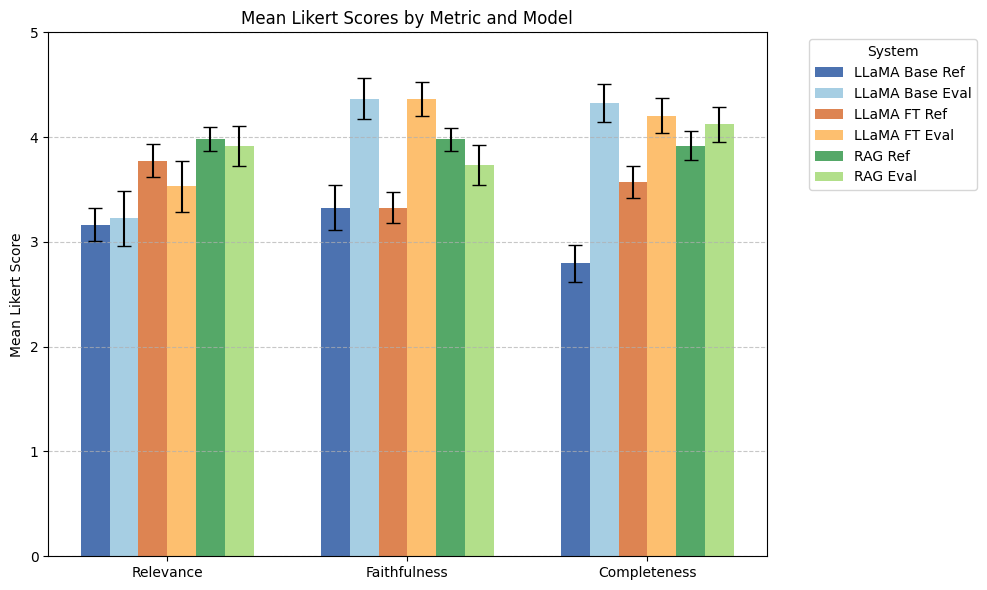

In [203]:
import matplotlib.pyplot as plt
import numpy as np

# Labels
categories = ['Relevance', 'Faithfulness', 'Completeness']
systems = ['LLaMA Base Ref', 'LLaMA Base Eval',
           'LLaMA FT Ref', 'LLaMA FT Eval',
           'RAG Ref', 'RAG Eval']

# Means: shape (3 categories x 6 systems)
means = np.array([
    [llama_base_ref_rel_likert_mean, llama_base_eval_rel_likert_mean,
     llama_ft_ref_res_likert_mean, llama_ft_eval_res_likert_mean,
     rag_ref_rel_likert_mean, rag_eval_rel_likert_mean],

    [llama_base_ref_faith_likert_mean, llama_base_eval_faith_likert_mean,
     llama_ft_ref_faith_likert_mean, llama_ft_eval_faith_likert_mean,
     rag_ref_faith_likert_mean, rag_eval_faith_likert_mean],

    [llama_base_ref_comp_likert_mean, llama_base_eval_comp_likert_mean,
     llama_ft_ref_comp_likert_mean, llama_ft_eval_comp_likert_mean,
     rag_ref_comp_likert_mean, rag_eval_comp_likert_mean]
])


# Standard deviations: shape (3 categories x 6 systems)
std_devs = np.array([
    [llama_base_ref_rel_likert_std, llama_base_eval_rel_likert_std,
     llama_ft_ref_res_likert_std, llama_ft_eval_res_likert_std,
     rag_ref_rel_likert_std, rag_eval_rel_likert_std],

    [llama_base_ref_faith_likert_std, llama_base_eval_faith_likert_std,
     llama_ft_ref_faith_likert_std, llama_ft_eval_faith_likert_std,
     rag_ref_faith_likert_std, rag_eval_faith_likert_std],

    [llama_base_ref_comp_likert_std, llama_base_eval_comp_likert_std,
     llama_ft_ref_comp_likert_std, llama_ft_eval_comp_likert_std,
     rag_ref_comp_likert_std, rag_eval_comp_likert_std]
])


sems = np.array([
    [llama_base_ref_rel_likert_sem, llama_base_eval_rel_likert_sem,
     llama_ft_ref_res_likert_sem, llama_ft_eval_res_likert_sem,
     rag_ref_rel_likert_sem, rag_eval_rel_likert_sem],

    [llama_base_ref_faith_likert_sem, llama_base_eval_faith_likert_sem,
     llama_ft_ref_faith_likert_sem, llama_ft_eval_faith_likert_sem,
     rag_ref_faith_likert_sem, rag_eval_faith_likert_sem],

    [llama_base_ref_comp_likert_sem, llama_base_eval_comp_likert_sem,
     llama_ft_ref_comp_likert_sem, llama_ft_eval_comp_likert_sem,
     rag_ref_comp_likert_sem, rag_eval_comp_likert_sem]
])


# Plot settings
x = np.arange(len(categories))
width = 0.12  # Width of each bar
n_systems = len(systems)
offsets = np.linspace(-width*(n_systems-1)/2, width*(n_systems-1)/2, n_systems)

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#4C72B0', '#A6CEE3',   # LLaMA Base: Ref (dark), Eval (light)
          '#DD8452', '#FDBF6F',   # LLaMA FT: Ref (dark), Eval (light)
          '#55A868', '#B2DF8A']   # RAG: Ref (dark), Eval (light)

for i in range(n_systems):
    ax.bar(x + offsets[i], means[:, i], width, yerr=sems[:, i],
           label=systems[i], capsize=5, color=colors[i])

# Formatting
ax.set_ylabel('Mean Likert Score')
ax.set_title('Mean Likert Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 5)
ax.legend(title='System', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


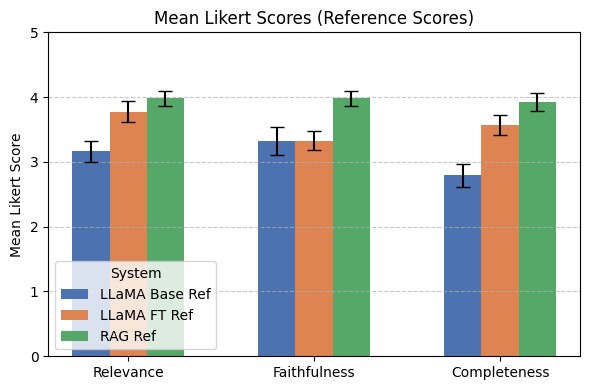

In [204]:
import matplotlib.pyplot as plt
import numpy as np

# Labels
categories = ['Relevance', 'Faithfulness', 'Completeness']
ref_systems = ['LLaMA Base Ref', 'LLaMA FT Ref', 'RAG Ref']
colors = ['#4C72B0', '#DD8452', '#55A868']  # Dark tones for Ref

# Reference Means (3 categories x 3 systems)
ref_means = np.array([
    [llama_base_ref_rel_likert_mean, llama_ft_ref_res_likert_mean, rag_ref_rel_likert_mean],
    [llama_base_ref_faith_likert_mean, llama_ft_ref_faith_likert_mean, rag_ref_faith_likert_mean],
    [llama_base_ref_comp_likert_mean, llama_ft_ref_comp_likert_mean, rag_ref_comp_likert_mean]
])

# Reference SEMs (3 categories x 3 systems)
ref_sems = np.array([
    [llama_base_ref_rel_likert_sem, llama_ft_ref_res_likert_sem, rag_ref_rel_likert_sem],
    [llama_base_ref_faith_likert_sem, llama_ft_ref_faith_likert_sem, rag_ref_faith_likert_sem],
    [llama_base_ref_comp_likert_sem, llama_ft_ref_comp_likert_sem, rag_ref_comp_likert_sem]
])

# Plot settings
x = np.arange(len(categories))
width = 0.2
n_systems = len(ref_systems)
offsets = np.linspace(-width, width, n_systems)

fig, ax = plt.subplots(figsize=(6, 4))  # Smaller figure

# Plot bars for each reference system
for i in range(n_systems):
    ax.bar(x + offsets[i], ref_means[:, i], width, yerr=ref_sems[:, i],
           label=ref_systems[i], capsize=5, color=colors[i])

# Formatting
ax.set_ylabel('Mean Likert Score')
ax.set_title('Mean Likert Scores (Reference Scores)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 5)
ax.legend(title='System')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


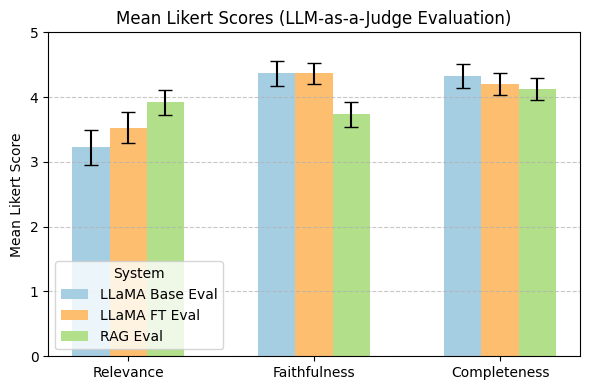

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Labels
categories = ['Relevance', 'Faithfulness', 'Completeness']
eval_systems = ['LLaMA Base Eval', 'LLaMA FT Eval', 'RAG Eval']
colors = ['#A6CEE3', '#FDBF6F', '#B2DF8A']  # Light tones for Eval

# Eval Means (3 categories x 3 systems)
eval_means = np.array([
    [llama_base_eval_rel_likert_mean, llama_ft_eval_res_likert_mean, rag_eval_rel_likert_mean],
    [llama_base_eval_faith_likert_mean, llama_ft_eval_faith_likert_mean, rag_eval_faith_likert_mean],
    [llama_base_eval_comp_likert_mean, llama_ft_eval_comp_likert_mean, rag_eval_comp_likert_mean]
])

# Eval SEMs (3 categories x 3 systems)
eval_sems = np.array([
    [llama_base_eval_rel_likert_sem, llama_ft_eval_res_likert_sem, rag_eval_rel_likert_sem],
    [llama_base_eval_faith_likert_sem, llama_ft_eval_faith_likert_sem, rag_eval_faith_likert_sem],
    [llama_base_eval_comp_likert_sem, llama_ft_eval_comp_likert_sem, rag_eval_comp_likert_sem]
])

# Plot settings
x = np.arange(len(categories))
width = 0.2
n_systems = len(eval_systems)
offsets = np.linspace(-width, width, n_systems)

fig, ax = plt.subplots(figsize=(6, 4))  # Smaller figure

# Plot bars for each eval system
for i in range(n_systems):
    ax.bar(x + offsets[i], eval_means[:, i], width, yerr=eval_sems[:, i],
           label=eval_systems[i], capsize=5, color=colors[i])

# Formatting
ax.set_ylabel('Mean Likert Score')
ax.set_title('Mean Likert Scores (LLM-as-a-Judge Evaluation)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 5)
ax.legend(title='System')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### RAG testing

In [165]:
num = 47

rag_eval_df.iloc[num]['question']

'How does the individual perceive wealth and worldly joy according to the passage?'

In [166]:
rag_eval_df.iloc[num]['answer']

'According to the passage, individuals who have earned merit strive to grow in virtue and seek the Lord, and for them, the world is for the Lord. These individuals do not perceive wealth and worldly joy as the purpose of life, but rather as fleeting pleasures to be pursued.'

In [167]:
rag_eval_df.iloc[num]

,47
question,How does the individual perceive wealth and wo...
answer,"According to the passage, individuals who have..."
relevance,3
faithfulness,2
completeness,3


In [168]:
rag_scored_df.iloc[num]

,47
question,How does the individual perceive wealth and wo...
answer,"According to the passage, individuals who have..."
relevance,4.0
faithfulness,5.0
completeness,5.0


In [169]:
rag_eval_df = rag_eval_df[['question', 'answer', 'relevance', 'faithfulness', 'completeness']]
rag_scored_df = rag_scored_df[['question', 'answer', 'relevance', 'faithfulness', 'completeness']]
rag_diff_df = rag_eval_df.compare(rag_scored_df)
rag_diff_count = rag_diff_df.notna().sum().sum()
print(f'{rag_diff_count/2}/{50*3}')

c = count_big_delta(rag_diff_df)

95.0/150
Number of self-to-other differences greater than 1: 27


In [170]:
rag_diff_df = rag_eval_df.compare(rag_scored_df)
# len(rag_compare)
# rag_diff_df

relevance       faithfulness       completeness      
        self other         self other         self other
0        NaN   NaN          NaN   NaN          4.0   1.0
1        2.0   4.0          2.0   3.0          2.0   3.0
2        5.0   4.0          5.0   4.0          5.0   4.0
4        NaN   NaN          2.0   4.0          NaN   NaN
5        5.0   4.0          5.0   4.0          5.0   4.0
6        5.0   4.0          NaN   NaN          NaN   NaN
7        2.0   3.0          2.0   4.0          2.0   1.0
9        2.0   5.0          2.0   4.0          2.0   4.0
10       3.0   4.0          3.0   4.0          NaN   NaN
11       1.0   2.0          1.0   2.0          NaN   NaN
13       5.0   4.0          NaN   NaN          5.0   4.0
15       5.0   4.0          5.0   4.0          5.0   4.0
16       NaN   NaN          2.0   3.0          3.0   4.0
17       NaN   NaN          4.0   3.0          4.0   3.0
18       1.0   3.0          1.0   4.0          1.0   4.0
19       NaN   NaN          4.0   3.0          NaN   NaN
20       5.0   4.0          5.0   4.0          5.0   4.0
23       5.0   3.0          4.0   3.0          5.0   3.0
24       NaN   NaN          4.0   5.0          NaN   NaN
26       NaN   NaN          NaN   NaN          5.0   4.0
27       3.0   4.0          3.0   4.0          NaN   NaN
28       NaN   NaN          4.0   5.0          NaN   NaN
29       5.0   3.0          4.0   3.0          NaN   NaN
30       5.0   3.0          5.0   3.0          5.0   4.0
31       NaN   NaN          3.0   4.0          5.0   4.0
32       3.0   4.0          3.0   4.0          NaN   NaN
33       5.0   3.0          5.0   4.0          5.0   4.0
34       2.0   5.0          2.0   5.0          4.0   5.0
35       5.0   4.0          5.0   4.0          5.0   4.0
36       4.0   3.0          5.0   3.0          5.0   3.0
37       5.0   4.0          5.0   4.0          5.0   4.0
38       2.0   3.0          3.0   4.0          NaN   NaN
39       1.0   3.0          1.0   3.0          2.0   3.0
40       4.0   5.0          3.0   5.0          4.0   5.0
42       2.0   4.0          2.0   3.0          2.0   3.0
43       5.0   4.0          5.0   4.0          5.0   4.0
45       5.0   4.0          5.0   4.0          5.0   4.0
46       3.0   4.0          3.0   4.0          NaN   NaN
47       3.0   4.0          2.0   5.0          3.0   5.0
48       5.0   4.0          5.0   3.0          5.0   4.0

# Visualization

# Export Excel

In [ ]:
with pd.ExcelWriter("/content/drive/MyDrive/Colab Notebooks/final_project_266/gpt_evaluator_scores_v1_8-2-2025.xlsx", engine="openpyxl") as writer:
    test_eval_df.to_excel(writer, index=False, sheet_name='unit_test_eval')
    unit_scores.to_excel(writer, index=False, sheet_name='unit_test_scores')
    llama_baseline_eval_df.to_excel(writer, index=False, sheet_name='llama_baseline_eval')
    llama_baseline_results_df.to_excel(writer, index=False, sheet_name='llama_baseline_results')
    llama_tuned_eval_df.to_excel(writer, index=False, sheet_name='llama_fine_tuned_eval')
    llama_tuned_scored_df.to_excel(writer, index=False, sheet_name='llama_fine_tuned_results')
    rag_eval_df.to_excel(writer, index=False, sheet_name='rag_eval')
    rag_scored_df.to_excel(writer, index=False, sheet_name='rag_results')

In [ ]:
rag_scored_df.head()

In [ ]:
total_results_df = pd.DataFrame(columns=['context',
                                         'question',
                                         'll_base_answer',
                                         'll_ft_answer',
                                         'rag_answer',
                                         'll_base_rel_ref',
                                         'll_base_relevance',
                                         'll_ft_rel_ref',
                                         'll_ft_relevance',
                                         'rag_rel_ref',
                                         'rag_relevance',
                                         'll_base_faith_ref',
                                         'll_base_faithfulness',
                                         'll_ft_faith_ref',
                                         'll_ft_faithfulness',
                                         'rag_faith_ref',
                                         'rag_faithfulness',
                                         'll_base_comp_ref',
                                         'll_base_completeness',
                                         'll_ft_comp_ref',
                                         'll_ft_completeness',
                                         'rag_comp_ref',
                                         'rag_completeness'])


total_results_df['context'] = llama_baseline_results_df['context']
total_results_df['question'] = llama_baseline_results_df['question']

total_results_df['ll_base_answer'] = llama_baseline_results_df['answer']
total_results_df['ll_ft_answer'] = llama_tuned_scored_df['answer']
total_results_df['rag_answer'] = rag_scored_df['answer']

total_results_df['ll_base_rel_ref'] = llama_baseline_results_df['relevance']
total_results_df['ll_base_relevance'] = llama_baseline_eval_df['relevance']
total_results_df['ll_ft_rel_ref'] = llama_tuned_scored_df['relevance']
total_results_df['ll_ft_relevance'] = llama_tuned_eval_df['relevance']
total_results_df['rag_rel_ref'] = rag_scored_df['relevance']
total_results_df['rag_relevance'] = rag_eval_df['relevance']

total_results_df['ll_base_faith_ref'] = llama_baseline_results_df['faithfulness']
total_results_df['ll_base_faithfulness'] = llama_baseline_eval_df['faithfulness']
total_results_df['ll_ft_faith_ref'] = llama_tuned_scored_df['faithfulness']
total_results_df['ll_ft_faithfulness'] = llama_tuned_eval_df['faithfulness']
total_results_df['rag_faith_ref'] = rag_scored_df['faithfulness']
total_results_df['rag_faithfulness'] = rag_eval_df['faithfulness']

total_results_df['ll_base_comp_ref'] = llama_baseline_results_df['completeness']
total_results_df['ll_base_completeness'] = llama_baseline_eval_df['completeness']
total_results_df['ll_ft_comp_ref'] = llama_tuned_scored_df['completeness']
total_results_df['ll_ft_completeness'] = llama_tuned_eval_df['completeness']
total_results_df['rag_comp_ref'] = rag_scored_df['completeness']
total_results_df['rag_completeness'] = rag_eval_df['completeness']

total_results_df.columns


In [ ]:
total_results_df.to_excel("/content/drive/MyDrive/Colab Notebooks/final_project_266/total_results_8-2-25.xlsx", index=False, sheet_name='total_results')

In [ ]:
# rag_eval_df.to_excel("/content/drive/MyDrive/Colab Notebooks/final_project_266/rag_eval_7-30-25.xlsx", index=False, sheet_name='rag_eval')